In [1]:
!pip install swig
!pip install gymnasium[box2d]
import warnings
warnings.filterwarnings("ignore")
import gymnasium as gym
import numpy as np
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379371 sha256=73fa21126c0b8d5bd6bffac470e6247df26169c919d9e45dc6a9ad88798b2693
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [2]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple


from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [3]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from collections import deque, namedtuple

In [4]:
class Network(nn.Module):
  def __init__(self, state_size, action_size, seed=42):
    super(Network, self).__init__()
    self.seed=torch.manual_seed(seed)
    self.fc1=nn.Linear(state_size,64)
    self.fc2=nn.Linear(64,64)
    self.fc3=nn.Linear(64,action_size)

  def forward(self,state):
    x=self.fc1(state)
    x=F.relu(x)
    x=self.fc2(x)
    x=F.relu(x)
    return self.fc3(x)


In [6]:
import gymnasium as gym
env=gym.make("LunarLander-v3")
state_shape=env.observation_space.shape
state_size=env.observation_space.shape[0]
number_action=env.action_space.n
print('State Shape :',state_shape)
print('State Size :',state_size)
print('Number of Actions :',number_action)

State Shape : (8,)
State Size : 8
Number of Actions : 4


In [7]:
learning_rate=5e-4
minibatch_size=100
discount_factor=0.99
replay_buffer_size=int(1e5)
interpolation_parameter=1e-3

In [8]:
class ReplayMemory(object):
  def __init__(self,capacity):
    self.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.capacity=capacity
    self.memory=[]

  def push(self,event):
    self.memory.append(event)
    if len(self.memory)>self.capacity:
      del self.memory[0]

  def sample(self,batch_size):
    experiences=random.sample(self.memory,k=batch_size)
    states=torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
    actions=torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
    rewards=torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
    next_states=torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
    dones=torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
    return states,next_states,actions,rewards,dones

In [9]:
class Agent():
  def __init__(self,state_size,action_size):
    self.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.state_size=state_size
    self.action_size=action_size
    self.local_qnetwork=Network(state_size,action_size).to(self.device)
    self.target_qnetwork=Network(state_size,action_size).to(self.device)
    self.optimizer=optim.Adam(self.local_qnetwork.parameters(),lr=learning_rate)
    self.memory=ReplayMemory(replay_buffer_size)
    self.t_step=0

  def step(self,state,action,reward,next_state,done):
    self.memory.push((state,action,reward,next_state,done))
    self.t_step=(self.t_step + 1) % 4
    if self.t_step==0:
      if len(self.memory.memory)>minibatch_size:
        experiences=self.memory.sample(100)
        self.learn(experiences,discount_factor)

  def act(self,state,epsilon=0.):
    state=torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    self.local_qnetwork.eval()
    with torch.no_grad():
      action_values=self.local_qnetwork(state)
    self.local_qnetwork.train()
    if random.random()>epsilon:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self,experiences,discount_factor):
    states,next_states,actions,rewards,dones=experiences
    next_q_targets=self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets=rewards + (discount_factor*next_q_targets*(1-dones))
    q_expected=self.local_qnetwork(states).gather(1,actions)
    loss=F.mse_loss(q_expected,q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.local_qnetwork,self.target_qnetwork,interpolation_parameter)
  def soft_update(self,local_model,target_model,interpolation_parameter):
    for target_param,local_param in zip(target_model.parameters(),local_model.parameters()):
      target_param.data.copy_(interpolation_parameter*local_param.data+(1.0-interpolation_parameter)*target_param.data)

In [10]:
agent = Agent(state_size,number_action)

In [11]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

show_video_of_model(agent, 'LunarLander-v3')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()

In [12]:
number_episodes=2000
maximum_number_timesteps_per_episode=1000
epsilon_starting_value=1.0
epsilon_ending_value=0.01
epsilon_decay_value= 0.99
epsilon=epsilon_starting_value
scores_on_100_episodes=deque(maxlen=200)

for episode in range(1,number_episodes+1):
  state,_=env.reset()
  score=0
  for t in range(maximum_number_timesteps_per_episode):
    action=agent.act(state,epsilon)
    next_state,reward,done,_,_=env.step(action)
    agent.step(state,action,reward,next_state,done)
    state=next_state
    score+=reward
    if done:
      break;
  scores_on_100_episodes.append(score)
  epsilon=max(epsilon_ending_value,epsilon_decay_value*epsilon)
  print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode,np.mean(scores_on_100_episodes)),end="")
  if episode%100==0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode,np.mean(scores_on_100_episodes)))
  if np.mean(scores_on_100_episodes)>=200.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode-100,np.mean(scores_on_100_episodes)))
    torch.save(agent.local_qnetwork.state_dict(),'checkpoint.pth')
    break;

Episode 100	Average Score: -181.56
Episode 200	Average Score: -124.24
Episode 300	Average Score: -54.52
Episode 400	Average Score: -31.23
Episode 500	Average Score: 10.50
Episode 600	Average Score: 76.45
Episode 700	Average Score: 140.76
Episode 800	Average Score: 194.38
Episode 813	Average Score: 200.02
Environment solved in 713 episodes!	Average Score: 200.02


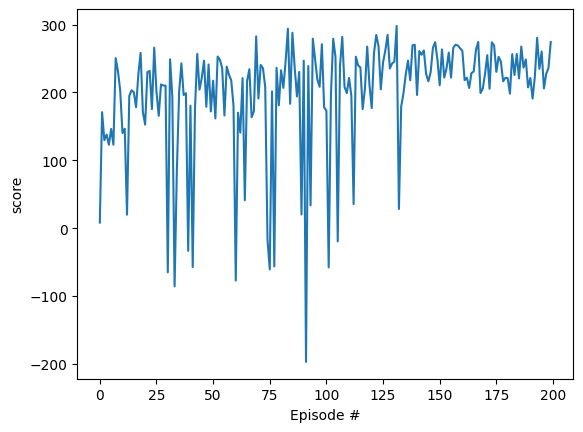

In [13]:

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_on_100_episodes)),scores_on_100_episodes)
plt.ylabel('score')
plt.xlabel('Episode #')
plt.show()

In [14]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

show_video_of_model(agent, 'LunarLander-v3')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()